In [1]:
import argparse                         # 加载处理命令行参数的库
import torch                            # 引入相关的包
import torch.nn as nn                   # 指定torch.nn别名nn
import torch.nn.functional as F         # 引用神经网络常用函数包，不具有可学习的参数
import torch.optim as optim
from torchvision import datasets, transforms  # 加载pytorch官方提供的dataset
import torchvision
from torch.utils import data
from d2l import torch as d2l

## 读取数据

In [8]:
batch_size=32
def get_dataloader_wokers():
    '''使用4个进程来读取数据'''
    return 4

def load_data_fashion_mnist(batch_size,resize=None):
    '''下载数据'''
    trans=[transforms.ToTensor()]
    #修改图片大小
    if resize:
        trans.insert(0,transforms.Resize(resize)) 
    trans=transforms.Compose(trans)
    #下载训练数据
    mnist_train = torchvision.datasets.FashionMNIST(
                    root="datasets",  #保存的目录
                    train=True,    #下载的是训练数据集
                    transform=trans,   #得到的是pytorch的tensor，而不是图片
                    download=True)  #从网上下载
    #下载测试数据
    mnist_test = torchvision.datasets.FashionMNIST(
        root="datasets", train=False, transform=trans, download=True)
    input_shape=mnist_train[0][0].shape
    return (data.DataLoader(mnist_train,batch_size,shuffle=True,  #生成一个迭代器
                            num_workers=get_dataloader_wokers()),
            data.DataLoader(mnist_test,batch_size,shuffle=False,
                            num_workers=get_dataloader_wokers()),input_shape)

In [1]:
train_iter, test_iter,input_shape= load_data_fashion_mnist(32, resize=40)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)

NameError: name 'load_data_fashion_mnist' is not defined

## 初始化模型参数



In [4]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(
    nn.Flatten(),    #全连接层
    nn.Linear(784, 10),  #784表示输入神经元数量，10表示输出神经元数量
    )

def init_w(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)  #我们仍然以均值0和标准差0.01随机初始化权重
net.apply(init_w)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## 损失函数

In [5]:
loss = nn.CrossEntropyLoss()  #交叉熵

## 优化算法

In [6]:
trainer=torch.optim.SGD(net.parameters(),lr=0.1)  #随机梯度下降算法

KeyboardInterrupt: 

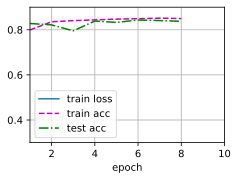

In [7]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 训练
*   通过调用net(X)生成预测并计算损失l（前向传播）。
*   通过进行反向传播来计算梯度。
*   通过调用优化器来更新模型参数。

In [10]:
num_epochs=3
for epoch in range(num_epochs):
    for x,y in train_iter:
        y_hat=net(x)     #预测值
        l=loss(y_hat,y)  #计算损失
        trainer.zero_grad()  #清除梯度
        l.backward()         #反向传播
        trainer.step()       #trainer步进 根据指定的优化算法进行参数的寻优

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1600 and 784x10)

## 定义softmax

回想一下，实现softmax由三个步骤组成：

*   对每个项求幂（使用exp）；

*   对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；

*   将每一行除以其规范化常数，确保结果的和为1。

![](picture//softmax1.jpg)

In [ ]:
def softmax(x):
    x_exp=torch.exp(x)
    partition=x_exp.sum(1,keepdim=True)  #对每一行求和
    return x_exp/partition  #运用了广播机制

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.6022, 0.1207, 0.0769, 0.0803, 0.1199],
         [0.0403, 0.0728, 0.8178, 0.0147, 0.0544]]),
 tensor([1.0000, 1.0000]))

## 定义模型